In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

%matplotlib inline

In [4]:
file_path = r"C:\Users\user1\Desktop\amz_uk_price_prediction_dataset.csv"
df = pd.read_csv(file_path)
print(df.head())

   uid        asin                                              title  stars  \
0    1  B09B96TG33  Echo Dot (5th generation, 2022 release) | Big ...    4.7   
1    2  B01HTH3C8S  Anker Soundcore mini, Super-Portable Bluetooth...    4.7   
2    3  B09B8YWXDF  Echo Dot (5th generation, 2022 release) | Big ...    4.7   
3    4  B09B8T5VGV  Echo Dot with clock (5th generation, 2022 rele...    4.7   
4    5  B09WX6QD65  Introducing Echo Pop | Full sound compact Wi-F...    4.6   

   reviews  price  isBestSeller  boughtInLastMonth        category  
0    15308  21.99         False                  0  Hi-Fi Speakers  
1    98099  23.99          True                  0  Hi-Fi Speakers  
2    15308  21.99         False                  0  Hi-Fi Speakers  
3     7205  31.99         False                  0  Hi-Fi Speakers  
4     1881  17.99         False                  0  Hi-Fi Speakers  


# Part 1: Analyzing Best-Seller Trends Across Product Categories
Objective: Understand the relationship between product categories and their best-seller status.

**1. Crosstab Analysis:**

- Create a crosstab between the product category and the isBestSeller status.

- Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

In [22]:
df.columns

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

In [54]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])
crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


- Are there categories where being a best-seller is more prevalent?

In [55]:
crosstab_percent = pd.crosstab(df['category'], df['isBestSeller'], normalize='index') * 100
crosstab_percent

isBestSeller,False,True
category,,
3D Printers,99.596774,0.403226
3D Printing & Scanning,99.950824,0.049176
Abrasive & Finishing Products,98.000000,2.000000
Action Cameras,99.941072,0.058928
Adapters,98.818898,1.181102
...,...,...
Wind Instruments,97.200000,2.800000
Window Treatments,97.907950,2.092050
Women,98.801485,1.198515


In [49]:
prevalent_best_sellers = crosstab_percent[True].sort_values(ascending=False)
prevalent_best_sellers

category
Grocery                             5.813467
Smart Home Security & Lighting      5.769231
Health & Personal Care              5.768628
Mobile Phone Accessories            4.247104
Power & Hand Tools                  3.533895
                                      ...   
CD, Disc & Tape Players             0.000000
General Music-Making Accessories    0.000000
Snowboard Boots                     0.000000
Boxes & Organisers                  0.000000
eBook Readers & Accessories         0.000000
Name: True, Length: 296, dtype: float64

**2. Statistical Tests:**

- Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

In [56]:
from scipy.stats import chi2_contingency

# Chi-square test for 'category' and 'isBestSeller'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

- Compute Cramér's V to understand the strength of association between best-seller status and category.

In [45]:
from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method="cramer")

0.1222829439760564

**3. Visualizations:**

- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

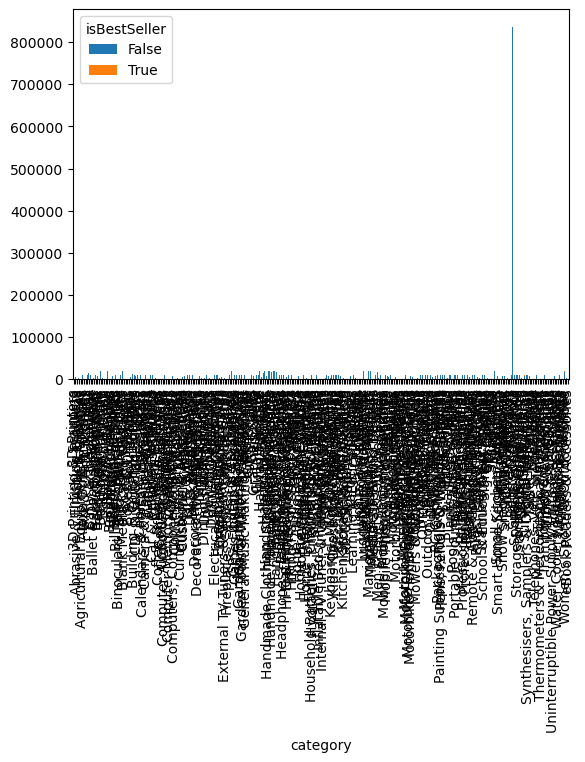

In [57]:
crosstab_result.plot(kind="bar", stacked=True)
plt.show()

In [61]:
# top 20
sorted_top_20 = crosstab_result.sort_values(True,ascending=False).head(20)
sorted_top_20

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
Beauty,19010,302
Pet Supplies,9152,285
Arts & Crafts,9319,230
Women,17559,213


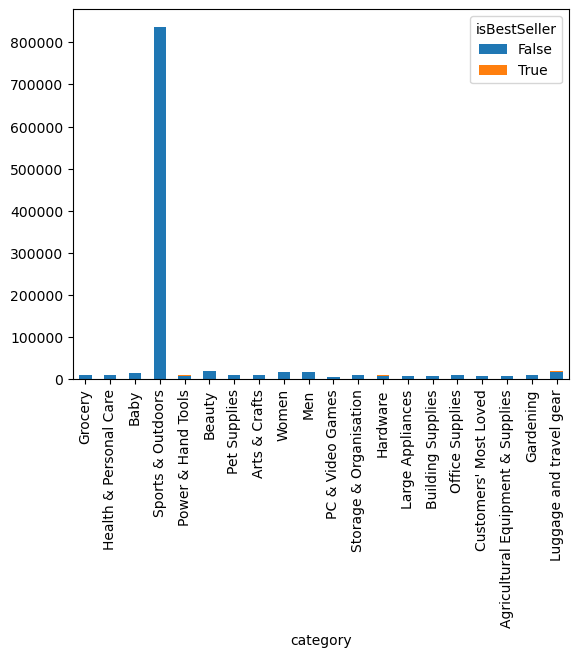

In [60]:
# top 20
sorted_top_20.plot(kind="bar", stacked=True)
plt.show()

# Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

**0. Preliminary Step: Remove outliers in product prices.**

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

In [72]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
    
# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
    
# Identify the outliers
clean = df[(df['price'] > lower_bound) & (df['price'] < upper_bound)]
    
clean

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


**1. Violin Plots:**

- Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
- Which product category tends to have the highest median price? Don't filter here by top categories.

In [133]:
# top 20
clean_top_20 = clean['category'].value_counts().sort_values(ascending=False).head(20)
clean_top_20.index

Index(['Sports & Outdoors', 'Beauty', 'Bath & Body',
       'Manicure & Pedicure Products',
       'Handmade Clothing, Shoes & Accessories', 'Make-up', 'Skin Care',
       'Hair Care', 'Birthday Gifts', 'Handmade Gifts', 'Handmade Home Décor',
       'Luggage and travel gear', 'Women', 'Fragrances',
       'Handmade Kitchen & Dining', 'Handmade Artwork',
       'Handmade Home & Kitchen Products', 'Handmade Jewellery', 'Men',
       'Baby'],
      dtype='object', name='category')

In [135]:
top_20_category = clean[clean['category'].isin(clean_top_20.index)]
top_20_category

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
19513,21072,B09477KHQ3,"Personalised Birthday Print Gift ""THE YEAR YOU...",4.5,763,7.99,False,900,Handmade Home & Kitchen Products
19514,21073,B0BSRFQYG8,Wax Melts 4 Bars | Build Your Own Box (Choose ...,3.9,117,6.49,True,800,Handmade Home & Kitchen Products
19515,21074,B09N9GVHV9,"Personalised Birthday Print Gift ""ON THE DAY/Y...",4.6,1155,8.99,True,600,Handmade Home & Kitchen Products
19516,21075,B0BRYGV7PQ,Fresh Wax Melts - Laundry Type Wax Melts - Str...,4.5,56,4.99,True,500,Handmade Home & Kitchen Products
19517,21076,B0B1JHB28R,Manta Makes Work Leaving Gifts | I Used to Wor...,4.7,261,9.95,True,400,Handmade Home & Kitchen Products
...,...,...,...,...,...,...,...,...,...
2429088,2806950,B0045I6SHW,Cannondale Men's Bibshort Dart Team Bike Shorts,0.0,0,99.67,False,0,Sports & Outdoors
2429089,2806951,B0045I6NZY,Cannondale Men's Baggy Fitness Bike Shorts,0.0,0,20.62,False,0,Sports & Outdoors
2429090,2806952,B003BLON3A,Pearl iZUMi Men's Phase Splice Knicker,4.3,3,59.86,False,0,Sports & Outdoors
2437153,2818782,B091HG57TP,Goodstoworld Boys Girls Tracksuit Bottoms 3D S...,4.2,554,14.99,False,0,Sports & Outdoors


C:\Users\user1\AppData\Local\Temp\ipykernel_8064\3582383945.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='category', y='price', data=top_20_category, palette="Set3")


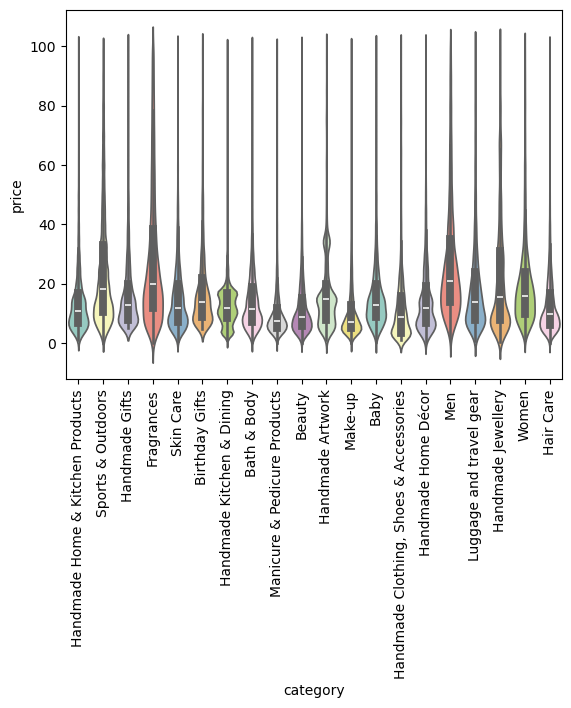

In [138]:
sns.violinplot(x='category', y='price', data=top_20_category, palette="Set3")
plt.xticks(rotation=90)

plt.show()

In [ ]:
top_categories = clean['category'].value_counts().head(10)

# Calculate the average price for these top categories
average_prices = clean.loc[clean['category'].isin(top_categories.index)].groupby('category')['price'].mean()

# Plotting the average prices for the top 10 categories
plt.figure(figsize=(10, 6))
sns.barplot(x=average_prices.index, y=average_prices.values, palette="Set3")
plt.title('Average Price of Products for Top 10 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

**2. Bar Charts:**

- Create a bar chart comparing the average price of products for the top 10 product categories (based on count).

In [141]:
clean_top_10 = clean['category'].value_counts().head(10)

top_10_category = clean[clean['category'].isin(clean_top_10.index)]
top_10_category

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
82163,89483,B07DLGZ828,Neutrade GoPro 3M Sticky Pads Double Sided Adh...,4.2,3116,6.49,False,0,Sports & Outdoors
82164,89484,B09HGZHXJT,"WOLFANG Action Camera 4K 20MP GA100, Waterproo...",4.2,2594,49.99,False,0,Sports & Outdoors
82167,89487,B08LD4VXGL,FitStill 60M/196FT Waterproof Case for Go Pro ...,4.5,9879,16.98,True,0,Sports & Outdoors
82168,89488,B07QDMLMJH,Nextbase Powered Mount Variations For Cameras ...,4.7,1223,19.95,False,0,Sports & Outdoors
82169,89489,B09TQMCNY7,WOLFANG Action Camera GA100 with 64GB microSDX...,4.2,55,49.99,False,0,Sports & Outdoors
...,...,...,...,...,...,...,...,...,...
2429088,2806950,B0045I6SHW,Cannondale Men's Bibshort Dart Team Bike Shorts,0.0,0,99.67,False,0,Sports & Outdoors
2429089,2806951,B0045I6NZY,Cannondale Men's Baggy Fitness Bike Shorts,0.0,0,20.62,False,0,Sports & Outdoors
2429090,2806952,B003BLON3A,Pearl iZUMi Men's Phase Splice Knicker,4.3,3,59.86,False,0,Sports & Outdoors
2437153,2818782,B091HG57TP,Goodstoworld Boys Girls Tracksuit Bottoms 3D S...,4.2,554,14.99,False,0,Sports & Outdoors


In [155]:
average_prices = top_category.groupby('category')['price'].mean().sort_values(ascending=False)
average_prices

category
Sports & Outdoors                         25.172065
Birthday Gifts                            18.600195
Handmade Gifts                            17.395112
Skin Care                                 15.654722
Bath & Body                               14.678683
Hair Care                                 13.461408
Handmade Clothing, Shoes & Accessories    12.958639
Beauty                                    12.523480
Make-up                                   10.612918
Manicure & Pedicure Products              10.231825
Name: price, dtype: float64

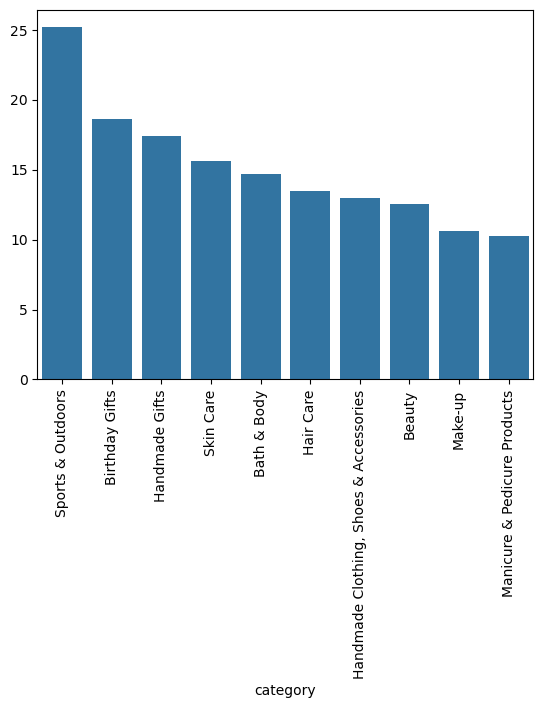

In [142]:
sns.barplot(x=average_prices.index, y=average_prices.values)
plt.xticks(rotation=90)

plt.show()

- Which product category commands the highest average price? Don't filter here by top categories.

In [108]:
average_prices = top_category.groupby('category')['price'].mean().sort_values(ascending=False)
average_prices

category
Sports & Outdoors                         25.172065
Birthday Gifts                            18.600195
Handmade Gifts                            17.395112
Skin Care                                 15.654722
Bath & Body                               14.678683
Hair Care                                 13.461408
Handmade Clothing, Shoes & Accessories    12.958639
Beauty                                    12.523480
Make-up                                   10.612918
Manicure & Pedicure Products              10.231825
Name: price, dtype: float64

In [114]:
average_prices.idxmax(),average_prices.max() 

('Sports & Outdoors', 25.17206487036301)

**3. Box Plots:**

- Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.


In [156]:
clean_top_10_ratings = clean['stars'].value_counts().head(10)
clean_top_10_ratings


stars
0.0    1001620
4.5     139854
4.6     126991
4.4     125615
5.0     114586
4.3     103415
4.7      86997
4.2      80069
4.0      60247
4.1      59498
Name: count, dtype: int64

In [158]:
top_10_category_ratings = clean[clean['stars'].isin(clean_top_10_ratings.index)].sort_values(ascending=False)
top_10_category_ratings

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

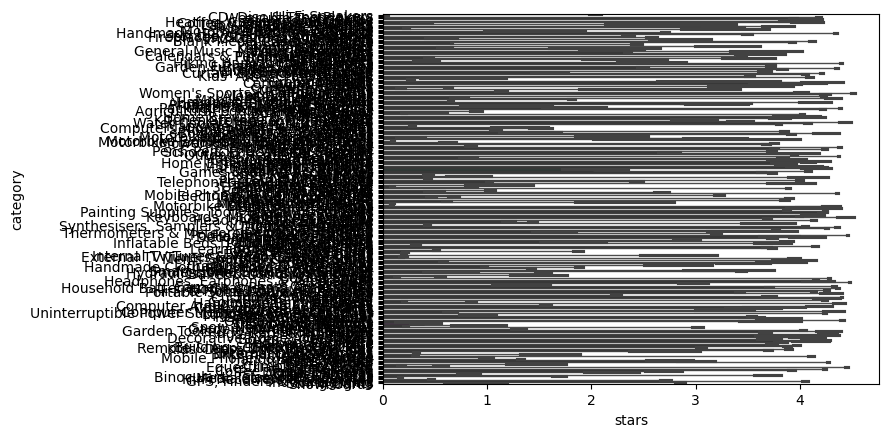

In [148]:
sns.barplot(data=top_10_category_ratings, x='stars', y='category', hue='category', dodge=True, alpha=0.7, edgecolor='black')
plt.show()

- Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [154]:
category_median = df.groupby('category')['stars'].median()
category_medians

category
3D Printers                       3.9
3D Printing & Scanning            0.0
Abrasive & Finishing Products     4.5
Action Cameras                    0.0
Adapters                          4.4
                                 ... 
Wind Instruments                  0.0
Window Treatments                 4.4
Women                             4.3
Women's Sports & Outdoor Shoes    4.3
eBook Readers & Accessories       0.0
Name: stars, Length: 296, dtype: float64

# Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

**1. Correlation Coefficients:**

- Calculate the correlation coefficient between price and stars.
- Is there a significant correlation between product price and its rating?

**2. Visualizations:**

- Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
- Use a correlation heatmap to visualize correlations between all numerical variables.
- Examine if product prices typically follow a normal distribution using a QQ plot.


Submission: Submit a Jupyter Notebook which contains code and a business-centric report summarizing your findings.



**Bonus:**

Do the same analysis without taking out the outliers. What are your insights?